In [33]:
import pandas as pd
# import gzip
import numpy as np
# import json
import matplotlib.pyplot as plt
import seaborn as sns

In [34]:
df_train = pd.read_csv('vlsp_sentiment_train.csv', sep='\t')
df_test = pd.read_csv('vlsp_sentiment_test.csv', sep='\t')

# Data preprocessing
1. Dropping empty rows in 2 column contain features

In [5]:
df_train.head()

,Class,Data
0,-1,"Mình đã dùng anywhere thế hệ đầu, quả là đầy t..."
1,-1,"Quan tâm nhất là độ trễ có cao không, dùng thi..."
2,-1,"dag xài con cùi bắp 98k....pin trâu, mỗi tội đ..."
3,-1,logitech chắc hàng phải tiền triệu trở lên dùn...
4,-1,"Đang xài con m175 cùi mía , nhà xài nhiều chuộ..."


2. Current data distribution

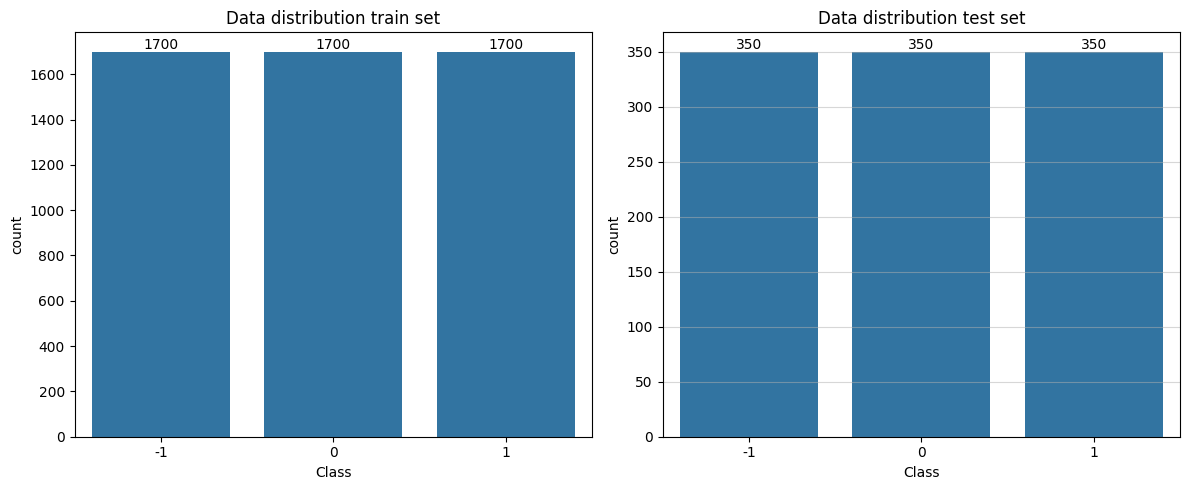

In [13]:
fig, ax = plt.subplots(1,2, figsize=(12,5)) 

sns.countplot(x='Class', data=df_train, ax = ax[0])
ax[0].bar_label(ax[0].containers[0])
ax[0].set_xlabel('Class')
ax[0].set_ylabel('count')
ax[0].set_title('Data distribution train set')

sns.countplot(x='Class', data=df_test, ax = ax[1])
ax[1].bar_label(ax[1].containers[0])
ax[1].set_xlabel('Class')
ax[1].set_ylabel('count')
ax[1].set_title('Data distribution test set')
plt.tight_layout()
plt.grid(visible=True,axis='y',alpha=0.5)
plt.show()

In [35]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
# from sklearn.feature_extraction.text import TfidfVectorizer
# import torch.nn.functional as F
import time
import pickle
from tqdm import tqdm

Ultility functions used to tokenize sentences

input = "I got an ice cream"

tokenize_output = ["I", "got", "an", "ice", "cream"]

In [36]:
from pyvi import ViTokenizer
from torchtext.vocab import build_vocab_from_iterator
import torchtext.transforms as T
def viTokenize(text):
    """
    Tokenize an English text and return a list of tokens
    """
    return ViTokenizer.tokenize(text).split()

def tokenize(data):
    for x in data:
        yield viTokenize(x)

In [37]:
vocab = build_vocab_from_iterator(
    tokenize(pd.concat([df_train['Data'], df_test['Data']])),
    min_freq=1,
    specials= ['<pad>', '<sos>', '<eos>', '<unk>'],
    special_first=True
)
vocab.set_default_index(vocab['<unk>'])


In [38]:
vocabsize = len(vocab)
print(vocabsize)

12625


In [39]:
from gensim.models.keyedvectors import KeyedVectors

word_vectors = KeyedVectors.load_word2vec_format('vi-model-CBOW.bin', binary=True)


vocabulary_size=min(vocabsize+1,10000)
embedding_matrix = np.zeros((vocabulary_size, 400))
print("vocab size", vocabulary_size)
for i, word in enumerate(vocab.get_itos()):
    if i>=10000:
        continue
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),400)

del(word_vectors)

embedding_matrix = torch.tensor(embedding_matrix)
print(embedding_matrix)

vocab size 10000
tensor([[ 1.0322,  0.0276,  0.7286,  ..., -1.1014,  0.5215, -0.2662],
        [-0.2884,  0.1719,  0.2185,  ...,  0.6269,  0.8333, -0.0041],
        [ 0.5406, -0.5764, -0.0540,  ...,  0.4782, -0.2172,  0.1246],
        ...,
        [ 0.2600, -0.8545,  0.0912,  ...,  0.6118, -0.5420, -0.0721],
        [-0.9853, -0.4096, -0.1447,  ..., -0.3955,  0.2767,  0.8836],
        [ 0.0186,  0.1258,  0.0999,  ..., -0.0922, -0.0308, -0.0166]],
       dtype=torch.float64)


Function to transform dataset into vectors given the vocabulary

In [40]:
def getTransform(vocab):
    """
    Create transforms based on given vocabulary. The returned transform is applied to sequence
    of tokens.
    """
    text_tranform = T.Sequential(
        ## converts the sentences to indices based on given vocabulary
        T.VocabTransform(vocab=vocab),
        ## Add <sos> at beginning of each sentence. 1 because the index for <sos> in vocabulary is
        # 1 as seen in previous section
        T.AddToken(1, begin=True),
        ## Add <eos> at beginning of each sentence. 2 because the index for <eos> in vocabulary is
        # 2 as seen in previous section
        T.AddToken(2, begin=False)
    )
    return text_tranform
def applyTransform(text):
    """
    Apply transforms to sequence of tokens in a sequence pair
    """

    return getTransform(vocab)(viTokenize(text))


In [41]:
x_train = df_train['Data'].apply(applyTransform)
x_test = df_test['Data'].apply(applyTransform)

In [42]:
y_train = []
y_test = []
label_train = df_train['Class'].values
label_test = df_test['Class'].values
for x in label_train:
    if x == -1:
        y_train.append([1,0,0])
    elif x == 0:
        y_train.append([0,1,0])
    elif x == 1:
        y_train.append([0,0,1])

for y in label_test:
    if y == -1:
        y_test.append([1,0,0])
    elif y == 0:
        y_test.append([0,1,0])
    elif y == 1:
        y_test.append([0,0,1])


In [13]:
print(x_train[0])
print(x_test[0])

[1, 75, 55, 13, 3239, 653, 301, 5, 668, 6, 556, 563, 5, 451, 72, 876, 3578, 4, 231, 7, 308, 5, 999, 66, 34, 12337, 5, 482, 2]
[1, 641, 846, 6, 16, 7, 7, 373, 76, 16, 17, 156, 4357, 5, 38, 716, 28, 114, 46, 53, 8213, 4, 75, 72, 935, 28, 30, 7234, 8976, 5, 59, 20, 164, 223, 26, 70, 2282, 1890, 5, 550, 779, 270, 59, 20, 2347, 42, 223, 77, 26, 70, 347, 327, 3283, 33, 632, 62, 30, 371, 5000, 16, 59, 101, 91, 43, 70, 2282, 1890, 11, 5841, 327, 3283, 4, 2]


In [16]:
print(y_train)

[[1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0]

In [43]:
# Define the dimensions
input_dim = min(vocabsize, 10000) # The dimension of your input data (e.g., vocabulary size)
hidden_dim = 1024  # Size of the hidden layer
embedding_dim =  400
output_dim = 3  # Two classes: positive and negative
learning_rate = 0.001
epochs = 100
batch_size = 128

Use device GPU for training

In [45]:
# if torch.cuda.is_available():
#     device = torch.device("cuda")
#     print("GPU available. Using GPU.")
# else:
device = torch.device("cpu")
print("GPU not available. Using CPU.")
print(device)

GPU not available. Using CPU.
cpu


The LSTM model, with the following structure:

- Word Embedding Layer
- 3 LSTM layer
- 1 fully connected layer
- Dropout layer

In [46]:
# Define the classification model
class SentimentClassifier(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        super(SentimentClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding.from_pretrained(embeddings=embedding_matrix)
        self.lstm = nn.LSTM(input_size= embedding_dim,hidden_size=hidden_dim)  
        # self.lstm1 = nn.LSTM(input_size= hidden_dim,hidden_size=128)  
        # self.lstm2 = nn.LSTM(input_size= 128,hidden_size=30)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.5)
        # self.sm = nn.LogSoftmax(dim=1)

    def forward(self, text, length):
        """text dim: padded sequence object with max length = length"""
        embedded = self.embedding(text)
        """embedded dimension: [length, batch size, embedding dim]"""
        # Pack the sequences for efficient processing
        packed_data = pack_padded_sequence(embedded, length.sum(1), batch_first=True, enforce_sorted=False)
        output, (hidden, cell) = self.lstm(packed_data)
        # output1, (hidden1, cell1) = self.lstm1(output)
        # output2, (hidden2, cell2) = self.lstm2(output1)
        """# output dim: [length, batch size, hidden dim]"""
        """# hidden dimension: [1, batch size, hidden dim]"""
        # unpacked_output, unpacked_length = pad_packed_sequence(output,batch_first=True)
        # unpacked_output.squeeze_(1)
        o = self.fc(hidden.squeeze(0))
        """hidden dim: [batch size, hidden dim]"""
        # o = self.dropout(o)
        # o = self.sm(o)
        return o

Dataset class (for pytorch)

In [47]:
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        """This function is called everytime we iterate through the dataloader"""
        # sample = {'data': self.data[idx], 'label': self.labels[idx]}
        return self.data.iloc[idx], self.labels[idx]



Data with different length vectors cannot be passed into an LSTM layer directly. To enable processing of variable-length sequences, padding is applied to ensure all vectors within a batch have the same length. For instance:

Original data:
```
data = [
    torch.tensor([16]),
    torch.tensor([204, 185, 65, 345]), 
    torch.tensor([204, 987]),
    torch.tensor([85, 4, 23])
]
```

Padded batch:
```
tensor([
    [ 16,   0,   0,   0], 
    [204, 185,  65, 345], 
    [204, 987,   0,   0], 
    [ 85,   4,  23,   0]
])
```

In this example, the vectors have been padded with zeros to match the length of the longest sequence within the batch, enabling their use in sequence-based models like LSTMs.

In [48]:
def custom_collate_fn(batch):
    data, labels = zip(*batch)

    # Sort sequences by length (from longest to shortest)
    sorted_data, sorted_labels = zip(*sorted(zip(data, labels), key=lambda x: len(x[0]), reverse=True))
    # Pad sequences to the length of the longest sequence
    padded_data = pad_sequence([torch.tensor(seq) for seq in sorted_data], batch_first=True)
    padded_labels = torch.tensor(sorted_labels).float()

    # Create a mask for the padded elements
    mask = (padded_data != 0).float()

    return padded_data.to(device), mask, padded_labels.to(device)

Intialize dataset and dataloader

In [49]:
torch.manual_seed(12)
trainset = CustomDataset(x_train, y_train)
testset = CustomDataset(x_test, y_test)

# trainset = CustomDataset(vocab_train, y_train_onehot)
# testset = CustomDataset(vocab_test, y_test)

# Create a DataLoader for your dataset
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


Model, Loss function and optimizer initilaization

In [32]:
# Instantiate the classifier
model = SentimentClassifier(input_dim, embedding_dim, hidden_dim, output_dim).to(device)
# Define the loss function (cross-entropy) and the optimizer (Adam)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
softmax = nn.Softmax(dim=1)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [18]:
for x,y,z in train_loader:
    print(x)
    print('AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA')
    print(y)
    print('AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA')
    print(z)
    print('AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA')
    # seq_unpacked, lens_unpacked = pad_packed_sequence(x, batch_first=True)
    # print(seq_unpacked)
    break

tensor([[   1,  641,  385,  ...,   18,   27,    2],
        [   1,  466,   16,  ...,    0,    0,    0],
        [   1,  248,   99,  ...,    0,    0,    0],
        ...,
        [   1, 7986,    2,  ...,    0,    0,    0],
        [   1, 8783,    2,  ...,    0,    0,    0],
        [   1,  337,    2,  ...,    0,    0,    0]], device='cuda:0')
AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.]])
AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
tensor([[0., 0., 1.],
        [1., 0., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
       

Try predicting without training

In [19]:
for x,y,z in test_loader:
    predictions = model(x,y)
    loss = criterion(predictions,z)
    # loss.backward()
    print(loss.item())
    
    predictions = softmax(predictions)
    predictions = torch.argmax(predictions, dim=1)
    true_label = torch.argmax(z, dim=1)
    result = predictions==true_label
    print(predictions)
    print(true_label)
    print(result)
    print(f"{result.float().mean()*100}%")
    break

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


Training loop and Testing loop

In [115]:
def trainloop(trainloader):
    epoch_train_loss = 0.0
    model.train()
    with tqdm(trainloader, unit="batch", desc='Training: ') as tbatch:
        for data, mask, labels in tbatch:
            optimizer.zero_grad()
            output = model(data, mask)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss
            tbatch.set_postfix(loss="{:.6f}".format(loss)) #loss of a batch
    return epoch_train_loss/len(trainloader) #loss accross the train set

def evaluateloop(testloader):
    model.eval()
    accuracy_tensor = torch.empty(0).to(device)
    with tqdm(testloader, unit="batch", desc='Evaluating: ') as ttest:
        with torch.no_grad():
            for data, mask, labels in ttest:
                predictions = model(data, mask)
                predictions = softmax(predictions)
                predictions = torch.argmax(predictions, dim=1)
                true_label = torch.argmax(labels, dim=1)
                batch_accuracy = predictions==true_label #accuracy of a single batch
                accuracy_tensor = torch.cat((accuracy_tensor, batch_accuracy), dim=0) #accuracy accoss test set
                ttest.set_postfix({'accuracy': batch_accuracy.float().mean().item()})
    accuracy = accuracy_tensor.float().mean()
    return accuracy

Function to save model in case of interuption and resume training from file

In [17]:
def checkpoint(model, optimizer, loss, epoch, filename):
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
        }, filename)
def resume(filename):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    return loss

In [145]:
start_time = time.time()
torch.manual_seed(0)
last_lost = 0.0 #the lost of the last epoch to determine stopping point
patience = 3 
trigger_times = 0 #counter for early stop
stop = False
start_epoch=0
curr_epoch = 0
delta = 0.01
counter = 0
try:
    with open('loss_values.pkl', 'rb') as f_loss, open('accuracy_values.pkl', 'rb') as f_accuracy:
        loss_array = pickle.load(f_loss)
        accuracy_array = pickle.load(f_accuracy)
except FileNotFoundError:
    # If files don't exist, initialize empty arrays
    loss_array = [] #used for graphing loss changes throughout training
    accuracy_array = [] 


if start_epoch>0:
    print("Found existing checkpoint, continue training")
    last_lost = resume(f'Model_at_epoch_{start_epoch}.pth')

try:
    for epoch in range(start_epoch, epochs):
        curr_epoch = epoch
        #Train
        train_loss = trainloop(train_loader)

        #Test
        accuracy = evaluateloop(test_loader)
        accuracy_array+=[accuracy]
        loss_array+=[train_loss]

        if counter%5==0:
            with open('loss_values.pkl', 'wb') as f_loss, open('accuracy_values.pkl', 'wb') as f_accuracy:
                pickle.dump(loss_array, f_loss)
                pickle.dump(accuracy_array, f_accuracy)

        counter+=1
        # Print statistics at the end of each epoch
        print(f'Epoch [{epoch+1}/{epochs}] | Test Accuracy: {accuracy:.2%} | Current Loss: {train_loss: .6f} | Delta = {abs(train_loss - last_lost)}\n')
        #Early stopping check
        if abs(train_loss - last_lost)<=delta:
            trigger_times+=1
        elif abs(train_loss - last_lost)>delta:
            trigger_times=0
        if trigger_times>=patience:
            stop = True
        last_lost=train_loss
        if stop == True:
            break
except KeyboardInterrupt:
    print("Training interrupted. Saving current model checkpoint.")
    checkpoint(model, optimizer, loss_array[-1], curr_epoch+1, f'Model_at_epoch_{curr_epoch+1}.pth')
    with open('loss_values.pkl', 'wb') as f_loss, open('accuracy_values.pkl', 'wb') as f_accuracy:
        pickle.dump(loss_array, f_loss)
        pickle.dump(accuracy_array, f_accuracy)

# Print total training time
print("Total training time: {:.2f} seconds".format(time.time() - start_time))
#Save model
checkpoint(model, optimizer, loss_array[-1], curr_epoch+1, f'Model_at_epoch_{curr_epoch+1}.pth')
with open('loss_values.pkl', 'wb') as f_loss, open('accuracy_values.pkl', 'wb') as f_accuracy:
    pickle.dump(loss_array, f_loss)
    pickle.dump(accuracy_array, f_accuracy)


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 43.39batch/s, accuracy=0.308]


Epoch [1/100] | Test Accuracy: 47.24% | Current Loss:  1.065449 | Delta = 1.0654493570327759



Evaluating: 100%|██████████| 9/9 [00:00<00:00, 43.81batch/s, accuracy=0.538]


Epoch [2/100] | Test Accuracy: 53.24% | Current Loss:  0.962537 | Delta = 0.10291212797164917



Evaluating: 100%|██████████| 9/9 [00:00<00:00, 42.57batch/s, accuracy=0.462]


Epoch [3/100] | Test Accuracy: 56.57% | Current Loss:  0.857976 | Delta = 0.10456156730651855



Evaluating: 100%|██████████| 9/9 [00:00<00:00, 43.80batch/s, accuracy=0.538]


Epoch [4/100] | Test Accuracy: 57.90% | Current Loss:  0.737291 | Delta = 0.12068462371826172



Evaluating: 100%|██████████| 9/9 [00:00<00:00, 45.12batch/s, accuracy=0.654]


Epoch [5/100] | Test Accuracy: 59.05% | Current Loss:  0.629751 | Delta = 0.10754036903381348



Evaluating: 100%|██████████| 9/9 [00:00<00:00, 46.28batch/s, accuracy=0.654]


Epoch [6/100] | Test Accuracy: 59.71% | Current Loss:  0.504884 | Delta = 0.1248665452003479



Evaluating: 100%|██████████| 9/9 [00:00<00:00, 44.02batch/s, accuracy=0.615]


Epoch [7/100] | Test Accuracy: 61.14% | Current Loss:  0.382607 | Delta = 0.12227696180343628



Evaluating: 100%|██████████| 9/9 [00:00<00:00, 41.02batch/s, accuracy=0.654]


Epoch [8/100] | Test Accuracy: 60.19% | Current Loss:  0.267740 | Delta = 0.11486667394638062



Evaluating: 100%|██████████| 9/9 [00:00<00:00, 41.78batch/s, accuracy=0.731]


Epoch [9/100] | Test Accuracy: 61.43% | Current Loss:  0.179317 | Delta = 0.08842311799526215



Evaluating: 100%|██████████| 9/9 [00:00<00:00, 47.00batch/s, accuracy=0.769]


Epoch [10/100] | Test Accuracy: 61.24% | Current Loss:  0.101655 | Delta = 0.07766212522983551



Evaluating: 100%|██████████| 9/9 [00:00<00:00, 43.18batch/s, accuracy=0.577]


Epoch [11/100] | Test Accuracy: 60.48% | Current Loss:  0.051760 | Delta = 0.04989561811089516



Evaluating: 100%|██████████| 9/9 [00:00<00:00, 43.38batch/s, accuracy=0.5]  


Epoch [12/100] | Test Accuracy: 56.86% | Current Loss:  0.082076 | Delta = 0.030316006392240524



Evaluating: 100%|██████████| 9/9 [00:00<00:00, 42.97batch/s, accuracy=0.385]


Epoch [13/100] | Test Accuracy: 59.90% | Current Loss:  0.057122 | Delta = 0.02495402842760086



Evaluating: 100%|██████████| 9/9 [00:00<00:00, 43.39batch/s, accuracy=0.538]


Epoch [14/100] | Test Accuracy: 60.00% | Current Loss:  0.014750 | Delta = 0.04237179085612297



Evaluating: 100%|██████████| 9/9 [00:00<00:00, 42.37batch/s, accuracy=0.615]


Epoch [15/100] | Test Accuracy: 60.29% | Current Loss:  0.006764 | Delta = 0.007985968142747879



Evaluating: 100%|██████████| 9/9 [00:00<00:00, 44.23batch/s, accuracy=0.615]


Epoch [16/100] | Test Accuracy: 60.00% | Current Loss:  0.002903 | Delta = 0.0038611076306551695



Evaluating: 100%|██████████| 9/9 [00:00<00:00, 44.67batch/s, accuracy=0.615]


Epoch [17/100] | Test Accuracy: 60.19% | Current Loss:  0.001553 | Delta = 0.0013494357699528337

Total training time: 50.27 seconds


Create some sentences for testing

In [131]:
test_sentence = 'i love this game'
test_sentence2 = 'trash game'
test_sentence3 = 'greate game i like it'
test_sentence4 = 'i regret buying it'
data = [test_sentence, test_sentence2, test_sentence3, test_sentence4]
result = [1,0,1,0]
column_names = ['text', 'positive']
df = pd.DataFrame(list(zip(data, result)), columns=column_names)

text = df['text']
label = df['positive']
evaluate = CustomDataset(text.apply(applyTransform),label.values)
evaloader = DataLoader(evaluate,batch_size=1, collate_fn=custom_collate_fn)

In [40]:
print(resume("model_colab\Model_at_epoch_33.pth"))

for batch, text in zip(evaloader,data):
    x,y,z= batch
    predictions = model(x,y)
#     print(predictions)
    result = (predictions>0).float()
    result = (result==z)
    if result == True:
        print(f'Prediction result: {text} - Correct')
    else:
        print(f'Prediction result: {text} - Incorrect')

0.030076907514478345
Prediction result: i love this game - Correct
Prediction result: trash game - Correct
Prediction result: greate game i like it - Correct
Prediction result: i regret buying it - Incorrect


In [108]:
resume("Model_at_epoch_24.pth")

tensor(0.0029, device='cuda:0', requires_grad=True)

Loss and Accuracy graph

[tensor(0.4724, device='cuda:0'), tensor(0.5324, device='cuda:0'), tensor(0.5657, device='cuda:0'), tensor(0.5790, device='cuda:0'), tensor(0.5905, device='cuda:0'), tensor(0.5971, device='cuda:0'), tensor(0.6114, device='cuda:0'), tensor(0.6019, device='cuda:0'), tensor(0.6143, device='cuda:0'), tensor(0.6124, device='cuda:0'), tensor(0.6048, device='cuda:0'), tensor(0.5686, device='cuda:0'), tensor(0.5990, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6029, device='cuda:0'), tensor(0.6000, device='cuda:0'), tensor(0.6019, device='cuda:0')]
[tensor(1.0654, device='cuda:0', requires_grad=True), tensor(0.9625, device='cuda:0', requires_grad=True), tensor(0.8580, device='cuda:0', requires_grad=True), tensor(0.7373, device='cuda:0', requires_grad=True), tensor(0.6298, device='cuda:0', requires_grad=True), tensor(0.5049, device='cuda:0', requires_grad=True), tensor(0.3826, device='cuda:0', requires_grad=True), tensor(0.2677, device='cuda:0', requires_grad=True), tensor(0.1793

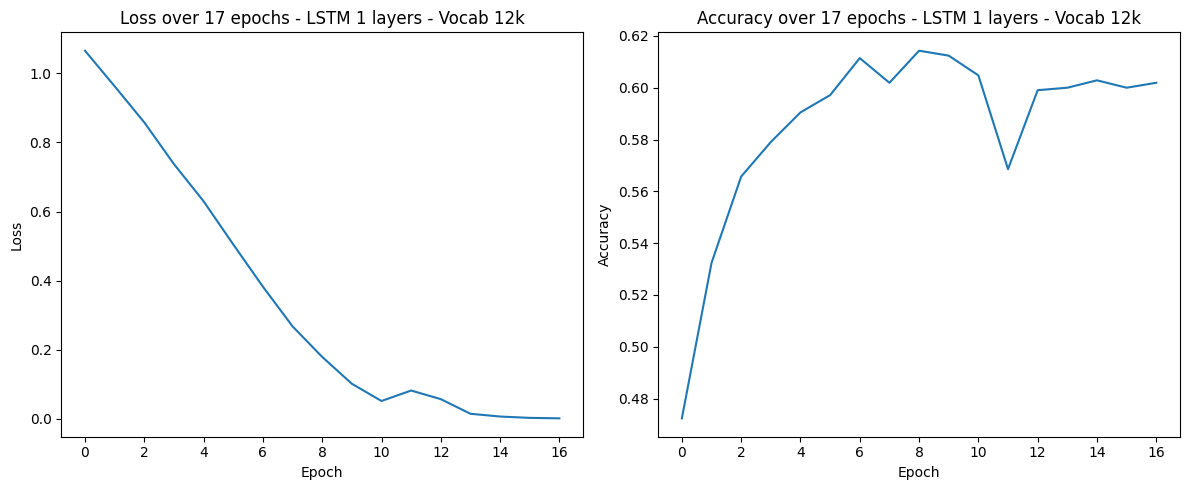

In [147]:
with open('accuracy_values.pkl', 'rb') as acc:
    acc_array = pickle.load(acc)
with open('loss_values.pkl', 'rb') as loss:
    loss_arrray = pickle.load(loss)
print(acc_array)
print(loss_arrray)
epoch = range(len(loss_arrray))

for i, x in enumerate(loss_arrray):
    loss_arrray[i] = x.item()
for i, x in enumerate(acc_array):
    acc_array[i] = x.item()
    
fig, ax = plt.subplots(1,2, figsize=(12,5)) 

ax[0].plot(epoch, loss_arrray)
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title(f'Loss over {len(loss_arrray)} epochs - LSTM 1 layers - Vocab 12k')

ax[1].plot(epoch, acc_array)
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].set_title(f'Accuracy over {len(accuracy_array)} epochs - LSTM 1 layers - Vocab 12k')
plt.tight_layout()
plt.show()

In [148]:
model.eval()

# Collect predictions and true labels
prediction_list = []
true_labels = []

with torch.no_grad():
    for x,y,z in test_loader:
        predictions = model(x,y)
        predictions = softmax(predictions)
        predictions = torch.argmax(predictions, dim=1)
        true_label = torch.argmax(z, dim=1)
        prediction_list.extend(predictions.cpu().numpy())
        true_labels.extend(true_label.cpu().numpy())
        # break
print(len(prediction_list))
print(len(true_labels))

1050
1050


In [149]:
prediction_list = np.array(prediction_list)
true_labels = np.array(true_labels)
label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
prediction_list = np.array([label_map[label] for label in prediction_list])
true_labels = np.array([label_map[label] for label in true_labels])


Classification report: 
               precision    recall  f1-score   support

    Negative       0.58      0.59      0.59       350
     Neutral       0.56      0.56      0.56       350
    Positive       0.66      0.66      0.66       350

    accuracy                           0.60      1050
   macro avg       0.60      0.60      0.60      1050
weighted avg       0.60      0.60      0.60      1050



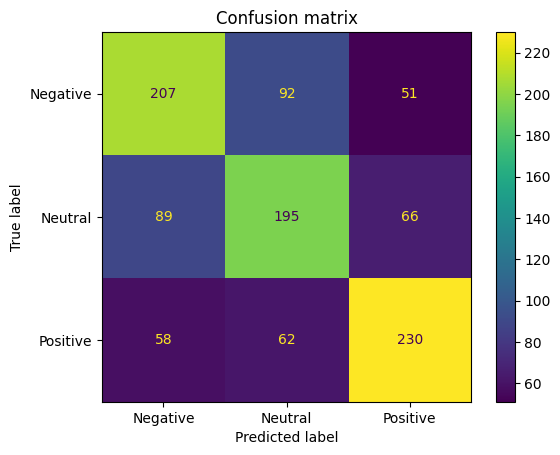

In [150]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, multilabel_confusion_matrix

print("Classification report: \n", classification_report(true_labels, prediction_list))
mcm = multilabel_confusion_matrix(true_labels, prediction_list)
disp = ConfusionMatrixDisplay.from_predictions(y_true=true_labels,y_pred=prediction_list)
plt.title("Confusion matrix")
plt.show()